In [15]:
import os
from tqdm.auto import tqdm
import shutil
import matplotlib.pyplot as plt
import numpy as np
from multiprocessing import Pool
import multiprocessing
import numpy as np
import shutil
import pickle as pkl
import gc

from scipy.signal import butter, lfilter, resample

import torch

import multiprocessing.pool as mpp

core_count = multiprocessing.cpu_count()

print(multiprocessing.cpu_count())

def istarmap(self, func, iterable, chunksize=1):
    """starmap-version of imap
    """
    if self._state != mpp.RUN:
        raise ValueError("Pool not running")

    if chunksize < 1:
        raise ValueError(
            "Chunksize must be 1+, not {0:n}".format(
                chunksize))

    task_batches = mpp.Pool._get_tasks(func, iterable, chunksize)
    result = mpp.IMapIterator(self._cache)
    self._taskqueue.put(
        (
            self._guarded_task_generation(result._job,
                                          mpp.starmapstar,
                                          task_batches),
            result._set_length
        ))
    return (item for chunk in result for item in chunk)

mpp.Pool.istarmap = istarmap


80


In [ ]:

data_path = '/labs/hulab/stark_stuff/ppg_ecg_project/data/'

def load_sigs(path, placeholder):
    sig = np.load(path)
    ecg = sig[:, 0]
    ppg = sig[:, 1]
    
    ecg = (ecg - np.min(ecg)) / (np.max(ecg) - np.min(ecg))
    ppg = (ppg - np.min(ppg)) / (np.max(ppg) - np.min(ppg))
    
    return ecg, ppg


def save_sig_npys(data_path, folder, split):
    paths = pkl.load(open(f'{data_path}/{folder}/split_{split}.pkl', 'rb'))
    ecgs = []
    ppgs = []
    pool_args = [[p, None] for p in paths]

    with Pool(core_count) as pool:
        for ret in tqdm(pool.istarmap(load_sigs, pool_args), total=len(pool_args)):
            ecgs.append(ret[0])
            ppgs.append(ret[1])
    
    ecgs = np.asarray(ecgs)
    ppgs = np.asarray(ppgs)
    print(ecgs.shape, ppgs.shape)
    
    np.save(f'{data_path}/{folder}/{split}_ECG.npy', ecgs)
    np.save(f'{data_path}/{folder}/{split}_PPG.npy', ppgs)
    
    del ecgs, ppgs, paths
    gc.collect()

In [ ]:
save_sig_npys(data_path, 'AF_v5', 'train')

In [ ]:
save_sig_npys(data_path, 'NSR_v5', 'train')

In [ ]:
save_sig_npys(data_path, 'NSR_v5', 'val')

In [ ]:
save_sig_npys(data_path, 'PVC_v5', 'train')

In [ ]:
save_sig_npys(data_path, 'PVC_v5', 'val')

In [ ]:
save_sig_npys(data_path, 'AF_v5', 'val')

In [7]:
tmp = np.load('/labs/hulab/stark_stuff/ppg_ecg_project/data/AF_v5/val_PPG_resampled2400.npy')

In [8]:
np.max(tmp)

1.0

In [9]:
np.min(tmp)

0.0

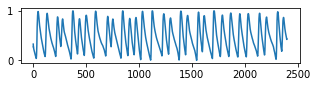

In [10]:
plt.figure(figsize=(5, 1))
plt.plot(tmp[2198])

In [31]:
testing_data_label_pairs = [
    # ['data_simband_ecg_2400.npy', 'label_simband.npy', '/labs/hulab/Robust_learning_TESTDATA/simband_patient_idx_dict.pkl'],
    # ['data_simband_ppg_2400.npy', 'label_simband.npy', '/labs/hulab/Robust_learning_TESTDATA/simband_patient_idx_dict.pkl'],
    # ['data_ucla_ecg_2400.npy', 'label_ucla_ecg.npy', '/labs/hulab/Robust_learning_TESTDATA/UCLA_patient_idx_dict.pkl'],
    # ['data_ucla_ppg_2400.npy', 'label_ucla_ppg.npy', '/labs/hulab/Robust_learning_TESTDATA/UCLA_patient_idx_dict.pkl'],
    # ['data_staford_2400.npy', 'label_staford.npy', '/labs/hulab/Robust_learning_TESTDATA/stanford_patient_idx_dict.pkl'],
    
    ['data_simband_goodquality_2400.npy', 'label_simband_goodquality.npy', '/labs/hulab/Robust_learning_TESTDATA/simband_patient_idx_dict.pkl'],
    ['data_simband_badquality_2400.npy', 'label_simband_badquality.npy', '/labs/hulab/Robust_learning_TESTDATA/simband_patient_idx_dict.pkl'],
    ['data_ucla_goodquality_2400.npy', 'label_ucla_goodquality.npy', '/labs/hulab/Robust_learning_TESTDATA/UCLA_patient_idx_dict.pkl'],
    ['data_ucla_badquality_2400.npy', 'label_ucla_badquality.npy', '/labs/hulab/Robust_learning_TESTDATA/UCLA_patient_idx_dict.pkl'],
    ['data_staford_goodquality_2400.npy', 'label_staford_goodquality.npy', '/labs/hulab/Robust_learning_TESTDATA/stanford_patient_idx_dict.pkl'],
    ['data_staford_badquality_2400.npy', 'label_staford_badquality.npy', '/labs/hulab/Robust_learning_TESTDATA/stanford_patient_idx_dict.pkl']
]

test_data_folder = '/labs/hulab/Robust_learning_TESTDATA/cheng_test/'
test_data_folder = '/labs/hulab/Robust_learning_TESTDATA/'

In [81]:
a = np.load(test_data_folder_1+'data_ucla_goodquality_2400.npy')
b = np.load(test_data_folder_1+'data_ucla_2400.npy')
patient_idx_dict = pkl.load(open('/labs/hulab/Robust_learning_TESTDATA/UCLA_patient_idx_dict.pkl', 'rb'))
print(min([min(v) for v in patient_idx_dict.values()]), max([max(v) for v in patient_idx_dict.values()]))
print(a.shape, b.shape)

0 251066
(151960, 2400) (259650, 2400)


In [77]:
staford_badquality_ref_idx_dict = dict()
found_index = set()
search_index = np.arange(b.shape[0])

for idxa, a1 in enumerate(tqdm(a)):
    for idxb, b1 in enumerate(tqdm(b)):
        if idxb in found_index: continue
        
        if np.array_equal(a1, b1):
            staford_badquality_ref_idx_dict[idxa] = idxb
            found_index.add(idxb)
            break

  0%|          | 0/13934 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:01<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:01<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:02<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

  0%|          | 0/17617 [00:00<?, ?it/s]

In [78]:
len(staford_badquality_ref_idx_dict)

13934

In [79]:
staford_badquality_ref_idx_dict

{0: 0,
 1: 1,
 2: 2,
 3: 3,
 4: 4,
 5: 5,
 6: 6,
 7: 7,
 8: 8,
 9: 9,
 10: 10,
 11: 11,
 12: 12,
 13: 13,
 14: 14,
 15: 15,
 16: 16,
 17: 17,
 18: 18,
 19: 19,
 20: 20,
 21: 21,
 22: 22,
 23: 23,
 24: 24,
 25: 25,
 26: 26,
 27: 27,
 28: 28,
 29: 29,
 30: 30,
 31: 31,
 32: 32,
 33: 33,
 34: 34,
 35: 35,
 36: 36,
 37: 37,
 38: 38,
 39: 39,
 40: 40,
 41: 41,
 42: 42,
 43: 43,
 44: 44,
 45: 45,
 46: 46,
 47: 47,
 48: 48,
 49: 49,
 50: 50,
 51: 51,
 52: 52,
 53: 53,
 54: 54,
 55: 55,
 56: 56,
 57: 57,
 58: 58,
 59: 59,
 60: 60,
 61: 61,
 62: 62,
 63: 63,
 64: 64,
 65: 65,
 66: 66,
 67: 67,
 68: 68,
 69: 69,
 70: 70,
 71: 71,
 72: 72,
 73: 73,
 74: 74,
 75: 75,
 76: 76,
 77: 77,
 78: 78,
 79: 79,
 80: 80,
 81: 81,
 82: 82,
 83: 83,
 84: 84,
 85: 85,
 86: 86,
 87: 87,
 88: 88,
 89: 89,
 90: 90,
 91: 91,
 92: 92,
 93: 93,
 94: 94,
 95: 95,
 96: 96,
 97: 97,
 98: 98,
 99: 99,
 100: 100,
 101: 101,
 102: 102,
 103: 103,
 104: 105,
 105: 117,
 106: 118,
 107: 135,
 108: 154,
 109: 158,
 110: 161,

In [80]:
pkl.dump(staford_badquality_ref_idx_dict, open("/labs/hulab/Robust_learning_TESTDATA/staford_badquality_ref_idx_dict.pkl", "wb"))